In [ ]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.dataloader import DataLoader

In [ ]:
!unzip /content/drive/MyDrive/Projects/Moret_colouring/data/gan-getting-started.zip

In [ ]:
monet_path = "/content/monet_jpg/*jpg"
photo_path = "/content/photo_jpg/*jpg"
from skimage.io import imread_collection
monet = imread_collection(monet_path)
photo = imread_collection(photo_path)

For Ease of Selecting data randomly from the collection we are using `set()` object in python. **Data Augmentation to be added in this place**

In [ ]:
monet_set = set()             # two data holding sets
photo_set = set()
for img in monet:
  image = torch.Tensor(img).cuda(0)
  image = image.permute(2,0,1)/255
  monet_set.update([image])   # as the time of update set iterates we use []

In [ ]:
for img in photo:
  image = torch.Tensor(img).cuda(0)
  image = image.permute(2,0,1)/255
  photo_set.update([image])

####Get Item
This function take a input set and returns desired size of tensor data  
Take a sample of size as `batch_size` and form a vector from those images

In [ ]:
from random import sample
def get_item(data : set,batch_size = 50) -> torch.TensorType:
  batch = torch.zeros((batch_size,3,256,256)).cuda(0)
  tensor_list = sample(data,k=batch_size)
  for i,im in enumerate(tensor_list):
    batch[i]= im.clone().detach()
  return batch

In [ ]:
batch = get_item(monet_set)
print(batch[0])

tensor([[[0.7843, 0.6471, 0.6431,  ..., 1.0000, 1.0000, 1.0000],
         [0.7020, 0.4941, 0.4431,  ..., 0.9961, 1.0000, 1.0000],
         [0.4627, 0.4118, 0.4000,  ..., 0.9647, 0.9686, 1.0000],
         ...,
         [0.8627, 0.6000, 0.4314,  ..., 0.9373, 0.9216, 0.9255],
         [0.9020, 0.9255, 0.8118,  ..., 0.9451, 0.9529, 0.9765],
         [0.8863, 0.9137, 0.8863,  ..., 0.9804, 0.9137, 0.9529]],

        [[0.7647, 0.6431, 0.6667,  ..., 0.9882, 0.9569, 0.9490],
         [0.7176, 0.5255, 0.4941,  ..., 0.9647, 0.9647, 0.9961],
         [0.5255, 0.4902, 0.4902,  ..., 0.9373, 0.9255, 0.9647],
         ...,
         [0.9059, 0.6510, 0.4902,  ..., 0.9412, 0.9333, 0.9412],
         [0.9451, 0.9765, 0.8784,  ..., 0.9529, 0.9686, 0.9922],
         [0.9294, 0.9686, 0.9529,  ..., 0.9922, 0.9294, 0.9725]],

        [[0.7804, 0.6667, 0.7137,  ..., 0.9137, 0.8706, 0.8588],
         [0.7216, 0.5373, 0.5294,  ..., 0.8902, 0.8784, 0.9020],
         [0.5137, 0.4941, 0.5137,  ..., 0.8627, 0.8392, 0.

## Generator


In [ ]:
class Generator(nn.Module):
  def __init__(self):
      super(Generator,self).__init__()
      self.conv1 = nn.Sequential(nn.Conv2d(3,8,kernel_size=3,padding=1,stride=2),
                                   nn.BatchNorm2d(8),
        nn.LeakyReLU())
      self.conv2 = nn.Sequential(nn.Conv2d(8,16,kernel_size=5,padding=2,stride=2),
                                  nn.BatchNorm2d(16),
      nn.LeakyReLU())
      self.conv3 = nn.Sequential(nn.Conv2d(16,32,kernel_size=3,padding=1,stride=2),
                                  nn.BatchNorm2d(32),
      nn.LeakyReLU())
      self.conv4 = nn.Sequential(nn.Conv2d(32,64,kernel_size=3,padding=1,stride=2),
                                  nn.BatchNorm2d(64),
      nn.LeakyReLU())
      self.bottleneck = nn.Sequential(nn.Conv2d(64,128,kernel_size=5,padding=2,stride=2),
      nn.LeakyReLU())

      # BottleNeck
      self.deconv5 = nn.Sequential(nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),
      nn.ReLU())
      self.deconv4 = nn.Sequential(nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),
      nn.ReLU())
      self.deconv3 = nn.Sequential(nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=1),
      nn.ReLU())
      self.deconv2 = nn.Sequential(nn.ConvTranspose2d(16,8,kernel_size=4,stride=2,padding=1),
      nn.ReLU())
      self.deconv1 = nn.Sequential(nn.ConvTranspose2d(8,3,kernel_size=4,stride=2,padding=1),
      nn.ReLU())
  def forward(self,xb : torch.TensorType ,) -> torch.TensorType:
      out1 = self.conv1(xb)
      #print("out1 ",out1.shape)
      out2 = self.conv2(out1)
      #print("out 2",out2.shape)
      out3 = self.conv3(out2)
      #print("out3 ",out3.shape)
      out4 = self.conv4(out3)
      out4 = self.bottleneck(out4)
      #print("after bottleneck",out4.shape)
      out4 = self.deconv5(out4)
      out4 = self.deconv4(out4)
      #print("after deconv4",out4.shape)
      out4 = self.deconv3(out4)
      #print("after deconv3",out4.shape)
      out4 = self.deconv2(out4)
      #print("after deconv2",out4.hape)
      out4 = self.deconv1(out4)
      #print("after deconv1",out4.shape)
      return out4


##Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
      super(Discriminator,self).__init__()
      self.conv = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=4,stride=4),
            nn.ReLU(),
            nn.Conv2d(16,64,kernel_size=4,stride=4),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=4,stride=4),
            nn.ReLU(),
            nn.Conv2d(128,64,kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64,16,kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(16,4,kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(4,1,kernel_size=1),
            nn.Sigmoid(),
            nn.Flatten()
            )
      self.linear = nn.Linear(16,1)
    def forward(self,x : torch.TensorType) -> torch.TensorType:
        out = self.conv(x)
        out = self.linear(out)
        return out

In [ ]:
gen_model = Generator()
dis_model = Discriminator()
gen_model.to('cuda')
dis_model.to('cuda')
print("done")

done


## Discriminator loss
Takes two inputs as real and fake image and return the average of the scores calculated using BCEwith logit loss


In [ ]:
def d_loss(discriminator,real,fake):
  real_score = discriminator(real)
  fake_score = discriminator(fake)

  loss_func = nn.BCEWithLogitsLoss()
  return (loss_func(real_score,torch.ones_like(real_score).cuda(0))+loss_func(fake_score,torch.zeros_like(real_score).cuda(0)))/2

## Generator loss
Generator tries to fool the discriminator using the discriminator loss and also tries to keep the generated photo close to the original photo by `l1_loss()`

In [ ]:
def g_loss(discriminator,origin,generated,l=1):
  loss_func = nn.BCEWithLogitsLoss()
  fake_score = discriminator(generated)
  return l*F.l1_loss(generated,origin) + (loss_func(fake_score,torch.ones_like(fake_score).cuda(0)))


In [ ]:
def fit(epochs,lr_g, lr_d,generator,discriminator,batch_size=50,opt_func=torch.optim.Adam):
  gen_opt = opt_func(generator.parameters(),lr_g)
  dis_opt = opt_func(discriminator.parameters(),lr_d)
  generator.train()
  discriminator.train()
  mean_gen_loss = 0
  mean_dis_loss = 0
  for epoch in range(epochs):

    real_monet = get_item(monet_set)
    photo = get_item(photo_set)
    #noise = torch.randn(batch_size,2,16,16).cuda(0)
    fake_monet = generator(photo)

    dis_opt.zero_grad()
    dis_loss = d_loss(discriminator,real_monet,fake_monet)
    dis_loss.backward(retain_graph=True)

    dis_opt.step()

    gen_opt.zero_grad()

    gen_loss = g_loss(discriminator,photo,fake_monet,100)
    gen_loss.backward()
    gen_opt.step()

    if(epoch%50==0):
      print(f"Step {epoch} :\n Gen_loss-> {gen_loss}\n Dis_loss-> {dis_loss}")

In [ ]:
fit(2000,0.00001,0.00001,gen_model,dis_model)

Step 0 :
 Gen_loss-> 8.258086204528809
 Dis_loss-> 0.4106143116950989
Step 50 :
 Gen_loss-> 9.00340461730957
 Dis_loss-> 0.43509864807128906
Step 100 :
 Gen_loss-> 9.05013370513916
 Dis_loss-> 0.4330040514469147
Step 150 :
 Gen_loss-> 8.774089813232422
 Dis_loss-> 0.4144793152809143
Step 200 :
 Gen_loss-> 9.012487411499023
 Dis_loss-> 0.4367592930793762
Step 250 :
 Gen_loss-> 7.9960246086120605
 Dis_loss-> 0.4294126033782959
Step 300 :
 Gen_loss-> 9.785717010498047
 Dis_loss-> 0.4204661250114441
Step 350 :
 Gen_loss-> 8.85573959350586
 Dis_loss-> 0.431646466255188
Step 400 :
 Gen_loss-> 8.38950252532959
 Dis_loss-> 0.4297388195991516
Step 450 :
 Gen_loss-> 8.817964553833008
 Dis_loss-> 0.4164048731327057
Step 500 :
 Gen_loss-> 8.6912841796875
 Dis_loss-> 0.41665998101234436
Step 550 :
 Gen_loss-> 9.242700576782227
 Dis_loss-> 0.41793370246887207
Step 600 :
 Gen_loss-> 9.053971290588379
 Dis_loss-> 0.4267527461051941
Step 650 :
 Gen_loss-> 8.062479972839355
 Dis_loss-> 0.414390265941619

In [ ]:
gen_model.eval()
dis_model.eval()
z = torch.randn(50,2,16,16).to('cuda')
im = get_item(photo_set)
fake = gen_model(im)
#print(dis_model(fake))
#print(fake[0].shape)
im = im.permute(0,2,3,1).detach().cpu().numpy()
fake = fake.permute(0,2,3,1).detach().cpu().numpy()
#print(fake.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


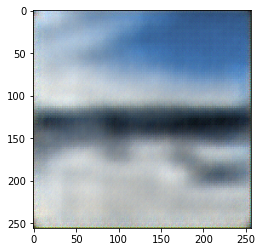

In [ ]:
import matplotlib.pyplot as plt
n=26
plt.imshow(fake[n])

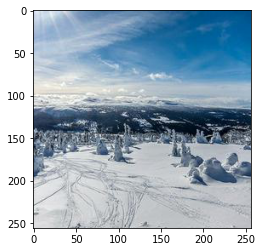

In [ ]:
plt.imshow(im[n])

In [ ]:
monet_im = get_item(monet_set)
mim = monet_im.permute(0,2,3,1).detach().cpu().numpy()

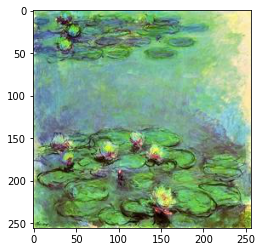

In [ ]:
plt.imshow(mim[32])